# Gameweek score predictor
The purpose of this model is to learn the relationship between a player's underlying performance and their gameweek score.
We know that goals, assists and clean sheets are how points are scored in the Fantasy Premier League game; however, these numbers are subject to a bit of luck. For example, a striker could take 10 shots on target in a match and not score any goals, while another player may take just one shot and score via a fortunate deflection. When looking at which players to transfer in / out of your team, looking at previous weeks' round totals only tells part of the story.

The aim of this tool is to provide some insights on which players _should_ have done well in previous weeks, based on their threat and creativity numbers.

**1. Influence**

Influence is the first measurement. This evaluates the degree to which that player has made an impact on a single match or throughout the season.

It takes into account events and actions that could directly or indirectly effect the outcome of the fixture.

At the top level these are decisive actions like goals and assists. But the Influence score also processes significant defensive actions to analyse the effectiveness of defenders and goalkeepers.

**2. Creativity**

Creativity assesses player performance in terms of producing goalscoring opportunities for others. It can be used as a guide to identify the players most likely to supply assists.

While this analyses frequency of passing and crossing, it also considers pitch location and quality of the final ball.

**3. Threat**

This is the third measure, producing a value that examines a player's threat on goal. It gauges individuals most likely to score goals.

While attempts are the key action, the Index looks at pitch location, giving greater weight to actions that are regarded as the best chances to score.

All three of these scores are combined to create an overall ICT Index score. That then offers a single figure that presents a view on that player as an FPL asset.

In [1]:
import requests, json, os
import pandas as pd
from pycaret.regression import *
pd.set_option('display.max_columns', None)

## Construct training set
All player gameweek scores from the 2019/2020 season will be used in the training set.

In [2]:
# get gameweek scores for every player
history = pd.read_csv('./data/2019-20/gameweek_history.csv')[
    ['id', 'fixture', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
     'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves',
     'bonus', 'bps', 'was_home', 'influence', 'creativity', 'threat', 'ict_index', 'total_points']]

history.head()

,id,fixture,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,was_home,influence,creativity,threat,ict_index,total_points
0,449,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0,0.0,0
1,454,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0,0.0,0
2,507,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0,0.0,0
3,289,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0,0.0,0
4,275,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,0.0,0.0,0,0.0,0


In [3]:
# player details - includes position and team
players = pd.read_csv('./data/2019-20/players.csv')[
    ['id', 'first_name', 'second_name', 'web_name', 'element_type', 'team']]

players.rename(columns={'team': 'team_id'}, inplace=True)

players.head()

,id,first_name,second_name,web_name,element_type,team_id
0,7,Laurent,Koscielny,Koscielny,2,1
1,8,Konstantinos,Mavropanos,Mavropanos,2,1
2,9,Carl,Jenkinson,Jenkinson,2,1
3,585,Tyreece,John-Jules,John-Jules,4,1
4,636,Zech,Medley,Medley,2,1


In [4]:
# team names
teams = pd.read_csv('./data/2019-20/teams.csv').rename(columns={'id': 'team_id', 'short_name': 'team_name'})
teams = teams[['team_id', 'team_name']]

teams.head()

,team_id,team_name
0,1,ARS
1,2,AVL
2,3,BOU
3,4,BHA
4,5,BUR


In [5]:
# player positions
positions = pd.read_csv('./data/2019-20/positions.csv').rename(columns={'id': 'element_type', 'name_short': 'position'})
positions = positions[['element_type', 'position']]

positions.head()

,element_type,position
0,1,GKP
1,2,DEF
2,3,MID
3,4,FWD


In [6]:
df = players.merge(positions, on='element_type')  # add player positions
df = df.merge(teams, on='team_id')  # add teams
df.drop(['element_type', 'team_id'], axis=1, inplace=True)
df = df.merge(history, on='id')  # add gameweek history
df.sort_values(['id', 'fixture'], inplace=True)
df = df[df['minutes']>0]  # remove gameweeks where players played 0 minutes
df.head(10)

,id,first_name,second_name,web_name,position,team_name,fixture,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,was_home,influence,creativity,threat,ict_index,total_points
426,1,Shkodran,Mustafi,Mustafi,DEF,ARS,137,90,0,1,0,2,0,0,0,0,0,0,0,24,False,19.8,0.8,54,7.5,4
424,1,Shkodran,Mustafi,Mustafi,DEF,ARS,182,13,0,0,0,0,0,0,0,0,0,0,0,3,False,2.8,0.2,0,0.3,1
425,1,Shkodran,Mustafi,Mustafi,DEF,ARS,191,67,0,0,0,2,0,0,0,0,0,0,0,8,True,9.6,0.2,0,1.0,1
434,1,Shkodran,Mustafi,Mustafi,DEF,ARS,221,90,0,0,0,1,0,0,0,0,0,0,0,14,True,24.6,1.2,19,4.5,2
427,1,Shkodran,Mustafi,Mustafi,DEF,ARS,238,90,0,1,0,2,0,0,0,0,0,0,1,28,False,54.8,10.5,2,6.7,5
428,1,Shkodran,Mustafi,Mustafi,DEF,ARS,242,90,0,0,1,0,0,0,0,0,0,0,0,24,False,17.2,0.3,4,2.2,6
429,1,Shkodran,Mustafi,Mustafi,DEF,ARS,251,90,0,0,1,0,0,0,0,0,0,0,0,24,True,19.4,1.4,24,4.5,6
430,1,Shkodran,Mustafi,Mustafi,DEF,ARS,261,90,0,0,0,2,0,0,0,0,0,0,0,19,True,26.0,0.8,4,3.1,1
422,1,Shkodran,Mustafi,Mustafi,DEF,ARS,275,90,0,0,0,3,0,0,0,0,0,0,0,8,False,8.8,0.0,0,0.9,1
431,1,Shkodran,Mustafi,Mustafi,DEF,ARS,293,90,0,0,0,2,0,0,0,0,0,0,0,17,False,24.4,25.7,17,6.7,1


In [7]:
df.shape

(10614, 26)

In [8]:
# keep only the features that will be used to train the model
train = df.drop(['id',
                 'first_name',
                 'second_name',
                 'web_name',
                 'team_name',
                 'fixture',
                 'goals_scored',
                 'assists',
                 'bonus',
                 'bps',
                 'was_home',
                 'influence',
                 'ict_index'], axis=1)

train.head()

,position,minutes,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,creativity,threat,total_points
426,DEF,90,0,2,0,0,0,0,0,0,0.8,54,4
424,DEF,13,0,0,0,0,0,0,0,0,0.2,0,1
425,DEF,67,0,2,0,0,0,0,0,0,0.2,0,1
434,DEF,90,0,1,0,0,0,0,0,0,1.2,19,2
427,DEF,90,0,2,0,0,0,0,0,0,10.5,2,5


## Model training
[PyCaret tutorial](https://github.com/pycaret/pycaret/blob/master/tutorials/Regression%20Tutorial%20Level%20Beginner%20-%20REG101.ipynb)

In [9]:
exp = setup(
    data=train,
    target='total_points',
    categorical_features=['position', 'clean_sheets', 'yellow_cards', 'red_cards'],
    numeric_features=['minutes', 'goals_conceded', 'penalties_saved', 'penalties_missed', 'saves', 'creativity', 'threat'],
    session_id=42,
    silent=True
)

,Description,Value
0,session_id,42
1,Target,total_points
2,Original Data,"(10614, 13)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(7429, 15)"


In [10]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.1560,4.1130,2.0259,0.5249,0.3780,0.4080,0.0410
catboost,CatBoost Regressor,1.1414,4.3429,2.0819,0.4981,0.3720,0.3960,2.9170
lightgbm,Light Gradient Boosting Machine,1.1552,4.4079,2.0961,0.4910,0.3789,0.3986,0.0140
lr,Linear Regression,1.4074,4.6816,2.1618,0.4586,0.4326,0.5583,0.2530
ridge,Ridge Regression,1.4080,4.6816,2.1618,0.4585,0.4328,0.5586,0.0040
br,Bayesian Ridge,1.4081,4.6818,2.1619,0.4585,0.4328,0.5586,0.0040
rf,Random Forest Regressor,1.1635,4.7511,2.1770,0.4507,0.3997,0.4129,0.0930
xgboost,Extreme Gradient Boosting,1.1794,4.8792,2.2058,0.4361,0.3967,0.4089,0.1920
et,Extra Trees Regressor,1.1809,5.2823,2.2962,0.3893,0.4147,0.4114,0.0780
knn,K Neighbors Regressor,1.3188,5.4313,2.3280,0.3726,0.4455,0.4858,0.0080


In [11]:
model = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1.0910,4.1875,2.0463,0.5203,0.3640,0.4136
1,1.1110,4.0055,2.0014,0.4871,0.3749,0.4343
2,1.0158,3.5971,1.8966,0.5375,0.3599,0.3840
3,1.1652,4.4672,2.1136,0.4987,0.3704,0.3966
4,1.2122,4.4080,2.0995,0.4641,0.3955,0.4205
5,1.1132,4.3905,2.0953,0.5090,0.3574,0.3602
6,1.1188,4.0168,2.0042,0.4566,0.3763,0.3947
7,1.2021,4.9432,2.2233,0.5094,0.3640,0.3679
8,1.1941,4.6405,2.1542,0.5016,0.3809,0.4248
9,1.1905,4.7729,2.1847,0.4963,0.3769,0.3632


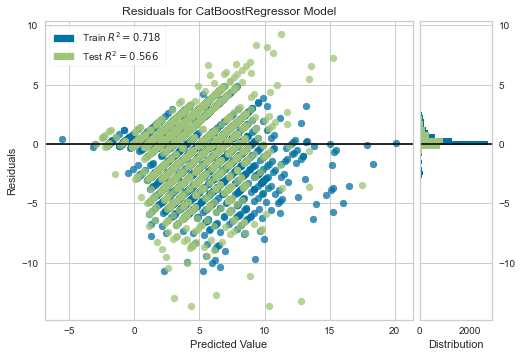

In [12]:
plot_model(model)

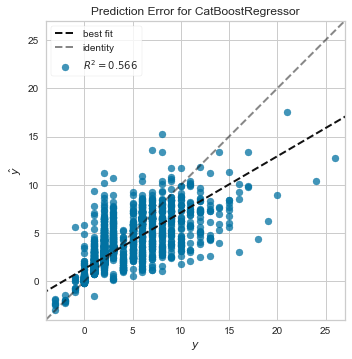

In [13]:
plot_model(model, plot='error')

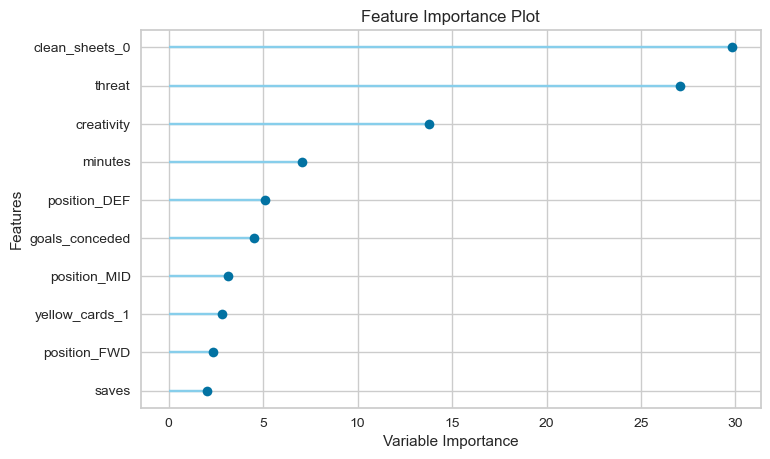

In [14]:
plot_model(model, plot='feature')

In [15]:
predict_model(model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1.1102,3.8918,1.9728,0.5661,0.3612,0.3955


,minutes,goals_conceded,penalties_saved,penalties_missed,saves,creativity,threat,position_DEF,position_FWD,position_GKP,position_MID,clean_sheets_0,own_goals_1,yellow_cards_1,red_cards_1,total_points,Label
0,90.0,1.0,0.0,0.0,0.0,13.300000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.306361
1,31.0,0.0,0.0,0.0,0.0,0.900000,48.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,4.277875
2,90.0,1.0,0.0,0.0,0.0,1.800000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.019099
3,90.0,1.0,0.0,0.0,0.0,0.100000,8.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.174587
4,69.0,0.0,0.0,0.0,0.0,18.000000,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.762891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3180,85.0,2.0,0.0,0.0,0.0,11.800000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.446868
3181,90.0,2.0,0.0,0.0,0.0,23.700001,36.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,4.889011
3182,22.0,0.0,0.0,0.0,0.0,10.400000,21.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.594205
3183,90.0,1.0,0.0,0.0,0.0,21.299999,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,2.612436
